# Setting up

In [1]:
!pip install -qq sentencepiece
!pip install -qq transformers==4.7.0
!pip install -qq unidecode

     |████████████████████████████████| 1.2 MB 7.7 MB/s 
     |████████████████████████████████| 2.5 MB 7.6 MB/s 
     |████████████████████████████████| 895 kB 52.8 MB/s 
     |████████████████████████████████| 3.3 MB 50.4 MB/s 
     |████████████████████████████████| 235 kB 7.9 MB/s 


In [2]:
!gdown --id -qq 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id -qq 141nsJ-dt-ZDR0aM1GkY2CGEmKeIM7O1F 
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!unzip -qq wassa_dataset.zip
!rm wassa_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
To: /content/codes.json
100% 216k/216k [00:00<00:00, 87.8MB/s]


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.utils
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
import re
import unidecode
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from transformers import MT5Tokenizer
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel, AlbertModel, AlbertTokenizer, AutoModel, AutoTokenizer

In [4]:
nltk.download("all") 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

# Loading the dataset

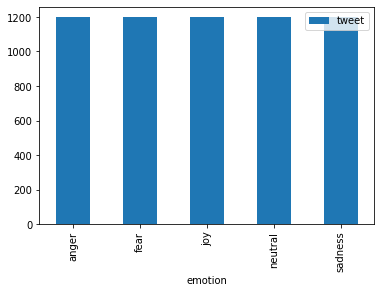

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [23]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")

n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()

print(n_samples)

In [24]:
df_train = df_train.query("emotion != 'neutral'")
df_val = df_val.query("emotion != 'neutral'")
df_test = df_test.query("emotion != 'neutral'")

In [25]:
print(df_train[:20])

      id                                              tweet  emotion
0   1929  Kinda wished I watched mischievous kiss before...      joy
1   4049  When you forget to mention you were bought dre...    anger
4   3712  Some moving clips on youtube tonight of the vi...    anger
5   2065  Do what makes you successful and #happy now an...      joy
7    118  Standard Candice starting the show with a pout...  sadness
8    522  [ @HedgehogDylan ] *she would frown a bit, fol...  sadness
10  4070  @SarahMi40605180 @kaileighhxo sorry to burst t...    anger
11   476  What a sad evening - clearing out all of Harve...  sadness
12  2662  @esanderc @MrsFridayNext It is very specific a...     fear
13   847  @AdamAaronovich Well, there's no need to sulk....  sadness
14  4698  oh these old things on my face? nah they're no...    anger
15  1537                          @Steeeevie_ breezy luvvvv      joy
16  1270  Watch this amazing live.ly broadcast by @brook...      joy
17  4255  The outrage over Kessel'

In [26]:
emotions_list=["joy", "anger", "fear", "sadness"]

In [27]:
texts_train = df_train.tweet.tolist()
texts_val = df_val.tweet.tolist()
texts_test = df_test.tweet.tolist()

label_encoder = LabelEncoder()
emotions_train = label_encoder.fit_transform(df_train.emotion.tolist())
emotions_val = label_encoder.transform(df_val.emotion.tolist())
emotions_test = label_encoder.transform(df_test.emotion.tolist())

#Preprocessing the dataset

In [28]:
def preprocess_text(text_list):
  for i, text in enumerate(text_list):
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", text)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    text_list[i] = result

In [29]:
preprocess_text(texts_train)
preprocess_text(texts_val)
preprocess_text(texts_test)

# Useful functions

In [30]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")




# Model and tokenizer selection functions





In [31]:
def get_model(model_name):
  model = None
  if model_name == 'bert-base-cased':
      model = BertModel.from_pretrained(model_name)

  if model_name == 'roberta-base':
      model = RobertaModel.from_pretrained(model_name)
 
  if model_name == 'vinai/bertweet-base':
      model = AutoModel.from_pretrained(model_name)

  return model

def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'bert-base-cased':
      tokenizer = BertTokenizer.from_pretrained(model_name)

    if model_name == 'roberta-base':
      tokenizer = RobertaTokenizer.from_pretrained(model_name)

    if model_name == 'vinai/bertweet-base':
      tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True, use_fast=False)
    
    return tokenizer

# Choosing the device and model

In [32]:
# this colab supports training for bert-base-cased roberta-base vinai/bertweet-base models
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
if tokenizer is None:
  print("Wrong model! Choose another one.")

In [33]:
epoch_dict = {"bert-base-cased" : 5, "roberta-base":5, "vinai/bertweet-base":5}
maxlen_dict = {"bert-base-cased" : 85, "roberta-base":170, "vinai/bertweet-base":90}

In [34]:
EPOCHS = epoch_dict[PRE_TRAINED_MODEL_NAME]
BATCH_SIZE = 16 # higher batch size might aid in the latter stages of fine tuning
maxlen = maxlen_dict[PRE_TRAINED_MODEL_NAME]
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

# Building the PyTorch datasets and dataloaders

In [35]:
class WassaDataset(Dataset):

  def __init__(self, texts, emotions, tokenizer, max_len):
    self.texts = texts
    self.emotions = emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    text = str(self.texts[item])
    emotion = self.emotions[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'emotions': torch.tensor(emotion, dtype=torch.long)
    }

In [36]:
def create_data_loader(texts, emotions, tokenizer, max_len, batch_size):
  dataset = WassaDataset(
    texts=texts,
    emotions=emotions,
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [37]:
train_data_loader = create_data_loader(texts_train, emotions_train, tokenizer, maxlen, BATCH_SIZE)
val_data_loader = create_data_loader(texts_val, emotions_val, tokenizer, maxlen, BATCH_SIZE)
test_data_loader = create_data_loader(texts_test, emotions_test, tokenizer, maxlen, BATCH_SIZE)

# Building the model

In [41]:
class EmotionsClassifier(nn.Module):
  def __init__(self, n_classes, model_name):
    super(EmotionsClassifier, self).__init__()
    self.bert = get_model(model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [42]:
model = EmotionsClassifier(len(emotions_list), PRE_TRAINED_MODEL_NAME)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EmotionsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [43]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

# Training and validation

In [44]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    emotions = d["emotions"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, emotions)
    correct_predictions += torch.sum(preds == emotions)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      emotions = d["emotions"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, emotions)
      correct_predictions += torch.sum(preds == emotions)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(texts_train)
  )

  print(f'Training loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(texts_val)
  )

  print(f'Validation loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Training loss 0.7098016660039623 accuracy 0.6970833333333334
Validation loss 0.3796146050291626 accuracy 0.8583333333333334

Epoch 2/5
----------
Training loss 0.2344470489785696 accuracy 0.925
Validation loss 0.24021396897488126 accuracy 0.9183333333333334

Epoch 3/5
----------
Training loss 0.1276746559480671 accuracy 0.96125
Validation loss 0.36437462634210915 accuracy 0.9183333333333334

Epoch 4/5
----------
Training loss 0.06964589916247253 accuracy 0.981875
Validation loss 0.3949410949809183 accuracy 0.925

Epoch 5/5
----------
Training loss 0.037689838605777674 accuracy 0.9918750000000001
Validation loss 0.4055427334464376 accuracy 0.9283333333333333

CPU times: user 4min 50s, sys: 1min 53s, total: 6min 44s
Wall time: 6min 52s


# Plotting training history

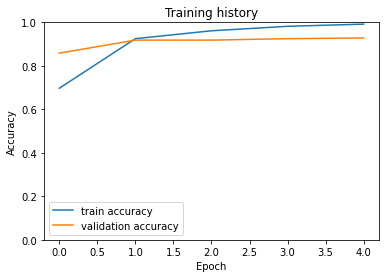

In [47]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# BERT_model Class





In [48]:
class Bert_model:
  def __init__(self, model, encoder, tokenizer, maxlen):
    self._model = model
    self._encoder = encoder
    self._tokenizer = tokenizer
    self._device = "cpu"
    self._maxlen = maxlen

  def set_device(self, device):
    self._device = device
    self._model.to(device)

  def _preprocess_text(self, text):
      # eliminate URLs
      result = re.result = re.sub(r"http\S+", "", text)
      # eliminate email addresses
      result = re.sub('\S*@\S*\s?', '', result)
      return result

  def _make_prediction_for_text(self, text):
    text = self._preprocess_text(text)
    encoding = self._tokenizer.encode_plus( 
        text,
        add_special_tokens=True,
        max_length=self._maxlen,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(self._device)
    attention_mask = encoding['attention_mask'].to(self._device)
    outputs = self._model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    outputs.to(self._device)
    return outputs.cpu().detach().numpy()

  def detect_emotions_with_labels(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion = self._make_prediction_for_text(text)
      pred = np.argmax(emotion, axis=1)
      prediction = self._encoder.inverse_transform(pred)
      predicted_emotions.append(prediction[0])
    return predicted_emotions
  
  def detect_emotions_with_proba(self, texts):
    predicted_emotions = []
    for text in texts:
      emotion_proba = self._make_prediction_for_text(text)
      predicted_emotions.append(emotion_proba)
    return np.concatenate(predicted_emotions)

In [49]:
bert_model = Bert_model(model, label_encoder, tokenizer, maxlen)

In [50]:
bert_model.set_device("cuda")

## Bert model validation

In [51]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_val)
y_true = label_encoder.inverse_transform(emotions_val)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.9283333333333333
, precision = 0.9288794468401684
, recall = 0.9283333333333333
, f1_score = 0.9284398678773227



In [52]:
print(classification_report(y_true, bert_predictions, target_names=emotions_list))

              precision    recall  f1-score   support

         joy       0.93      0.92      0.93       150
       anger       0.88      0.92      0.90       150
        fear       0.94      0.91      0.93       150
     sadness       0.95      0.96      0.96       150

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



## Bert model testing

In [53]:
bert_predictions = bert_model.detect_emotions_with_labels(texts_test)
y_true = label_encoder.inverse_transform(emotions_test)
compute_metrics(y_true, bert_predictions)

Model has acc = 0.8983333333333333
, precision = 0.8982223582908514
, recall = 0.8983333333333334
, f1_score = 0.89814008540716



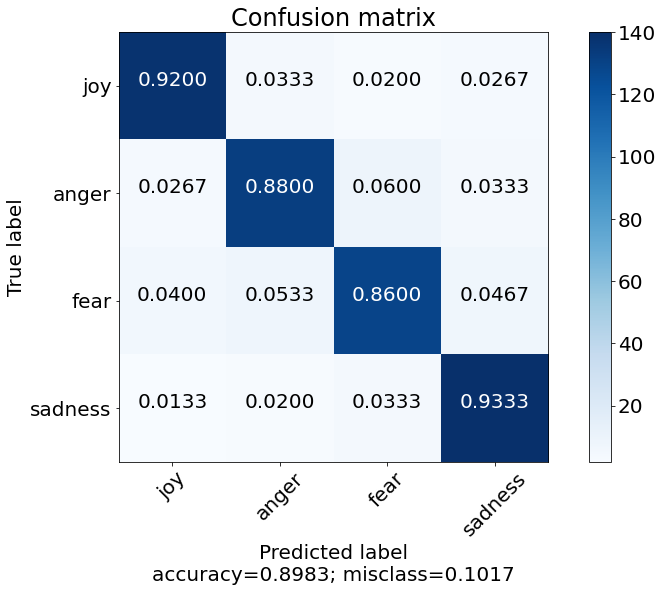

In [54]:
cm = confusion_matrix(y_true, bert_predictions, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

# Building the ensemble model

## Adding the SVM model to the ensemble model

In [61]:
class SVM_model:
  def __init__(self, classifier, encoder, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._stop_words = stop_words
    self._vectorizer = vectorizer
  
  def _preprocess_text(self, text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")
    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "
    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

In [62]:
svm_model = pickle_load_object("svm_model.obj")

## Ensemble model testing

In [63]:
bert_predictions = bert_model.detect_emotions_with_proba(texts_test)
svm_predictions = svm_model.detect_emotions_with_proba(texts_test)
# combine results for the ensemble model
predictions = svm_predictions+bert_predictions 

In [64]:
y_true = label_encoder.inverse_transform(emotions_test)

In [65]:
# get labels from ensemble model
predicted_emotions_inv = svm_model.proba_to_labels(predictions)

In [66]:
acc = accuracy_score(y_true, predicted_emotions_inv)
acc

0.94

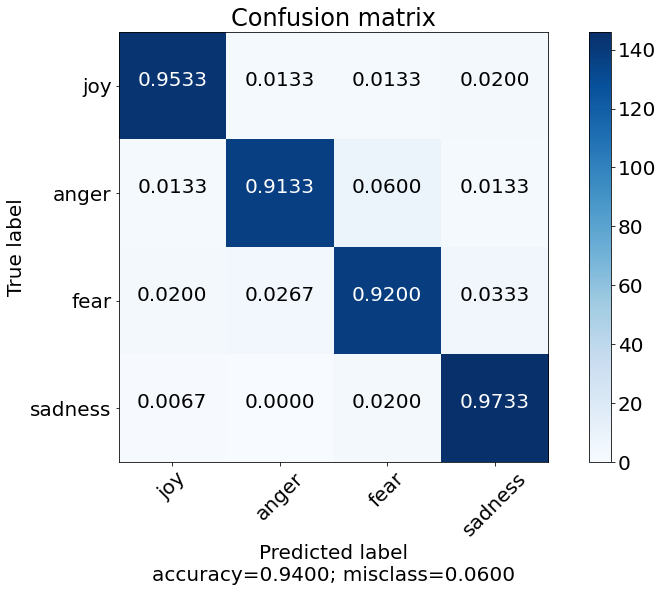

In [67]:
cm = confusion_matrix(y_true, predicted_emotions_inv, labels=emotions_list)
plot_confusion_matrix(cm, emotions_list)

## Ensemble model class

In [68]:
class Ensemble_Model:
  def __init__(self, bert_model, svm_model):
    self._bert_model = bert_model
    self._svm_model = svm_model
  
  def set_bert_device(self, device):
    self._bert_model.set_device(device)

  def detect_emotions(self, texts):
    svm_predictions = self._svm_model.detect_emotions_with_proba(texts)
    bert_predictions = self._bert_model.detect_emotions_with_proba(texts)
    predictions = svm_predictions+bert_predictions
    return self._svm_model.proba_to_labels(predictions)


##  Ensemble model validation

In [69]:
en_model = Ensemble_Model(bert_model, svm_model)

In [70]:
en_model.set_bert_device("cpu")

In [71]:
predictions = en_model.detect_emotions(texts_test)

In [72]:
acc = accuracy_score(df_test.emotion.tolist(), predictions)
acc

0.94

In [73]:
print(classification_report(df_test.emotion.tolist(), predictions, target_names=emotions_list))

              precision    recall  f1-score   support

         joy       0.96      0.91      0.94       150
       anger       0.91      0.92      0.91       150
        fear       0.96      0.95      0.96       150
     sadness       0.94      0.97      0.95       150

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [74]:
pickle_object(en_model, "english_model.obj")

In [76]:
predictions = en_model.detect_emotions(["I am sitting home", "New York is a big city", "The president has arrived"])
predictions

['anger', 'fear', 'fear']